# Manufacturing Parts Quality Analysis

## Background
Manufacturing processes for any product are like putting together a puzzle. Products are pieced together step by step, and keeping a close eye on the process is important. For this project, I'm supporting a team that wants to improve how they monitor and control a manufacturing process. The goal is to implement a more methodical approach known as statistical process control (SPC). SPC is an established strategy that uses data to determine whether the process works well. Processes are only adjusted if measurements fall outside of an acceptable range.

## Data Overview
The historical manufacturing data (parts.csv) has been pre-cleaned and comprises the following columns:

- length: The length of the item made.
- width: The width of the item made.
- height: The height of the item made.
- operator: The operating machine.

In [1]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Import the data
manufacturing_parts = pd.read_csv('parts.csv')
manufacturing_parts

,item_no,length,width,height,operator
0,1,102.67,49.53,19.69,Op-1
1,2,102.50,51.42,19.63,Op-1
2,3,95.37,52.25,21.51,Op-1
3,4,94.77,49.24,18.60,Op-1
4,5,104.26,47.90,19.46,Op-1
...,...,...,...,...,...
495,496,101.24,49.03,20.96,Op-20
496,497,98.37,52.12,19.68,Op-20
497,498,96.49,48.78,19.19,Op-20
498,499,94.16,48.39,21.60,Op-20


## Challenge

The team has defined the acceptable range by an upper control limit (UCL) and a lower control limit (LCL), the formulas for which are:

$ucl = avg\_height + 3 * \frac{stddev\_height}{\sqrt{5}}$

$lcl = avg\_height - 3 * \frac{stddev\_height}{\sqrt{5}}$

The UCL defines the highest acceptable height for the parts, while the LCL defines the lowest acceptable height for the parts. Ideally, parts should fall between the two limits.

Using SQL window functions and CTEs, I'll analyze historical manufacturing data to define this acceptable range and identify any points in the process that fall outside of the range and therefore require adjustments. This will ensure a smooth-running manufacturing process consistently making high-quality products. Additionally, I'll analyze operator performance to gain insights that improve the manufacturing process to consistently make high-quality products.

## Executive Summary

**Purpose:** This analysis aims to evaluate a dataset of manufacturing parts to derive insights about operator performance and its impact on product quality, with a specific focus on the acceptable height range of the parts.

**Problem:** The primary challenge was to identify which operators are associated with the highest number of parts falling outside the acceptable height range, assess the extent of the issue, and provide actionable recommendations to enhance the manufacturing process.

**Data Preprocessing:** Comprehensive data profiling was conducted to understand the dataset thoroughly. The data was pre-cleaned, ensuring its readiness for analysis.

**Analysis:** Our analysis identified 57 instances where the height of manufactured parts exceeded the acceptable range, accounting for 11.4% of all manufactured parts. This suggests a potential area for improvement in the manufacturing process. Depending on the team's quality standards, this percentage may or may not be within acceptable limits.

Every operator produced at least one part outside the acceptable height range. Operator 5 had the highest number of instances with 6 unacceptable parts, while operators 18, 1, 12, and 6 each had only 1 unacceptable part. On average, each operator produced approximately 2.85 parts that did not meet the height criteria. This average indicates that while some operators have a higher frequency of producing non-conforming parts, the issue is widespread across the team.

The high number of alerts for certain operators could stem from various factors, including inadequate training, equipment malfunctions, or inconsistencies in the manufacturing process.

**Conclusion and Recommendation:** The analysis indicates that specific operators are more frequently associated with parts falling outside the acceptable height range, highlighting potential areas for improvement in the manufacturing process.

Based on the analysis, we recommend conducting a thorough review of the operators with the highest alert counts to identify the root causes. This may involve observing their work processes, checking the calibration of their equipment, and reviewing their training records. The team may also want to consider implementing targeted training programs, equipment maintenance schedules, or process adjustments to reduce the number of parts falling outside the acceptable height range.

By addressing these issues, we can enhance the consistency and quality of the manufacturing process, ultimately reducing the number of unacceptable parts and improving overall product quality.

## Data Profiling
To gain a comprehensive understanding of the dataset, let's examine the structure, quality, and statistical properties of the data. As this dataset has been pre-cleaned, additional data cleaning steps are not required.

What does the data look like?

In [2]:
SELECT * FROM manufacturing_parts

,item_no,length,width,height,operator
0,1,102.67,49.53,19.69,Op-1
1,2,102.50,51.42,19.63,Op-1
2,3,95.37,52.25,21.51,Op-1
3,4,94.77,49.24,18.60,Op-1
4,5,104.26,47.90,19.46,Op-1
...,...,...,...,...,...
495,496,101.24,49.03,20.96,Op-20
496,497,98.37,52.12,19.68,Op-20
497,498,96.49,48.78,19.19,Op-20
498,499,94.16,48.39,21.60,Op-20


How many rows and columns does it have?

In [3]:
manufacturing_parts.shape

(500, 5)

What are the column names and data types? How many non-null values does each column have?

In [4]:
manufacturing_parts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_no   500 non-null    int64  
 1   length    500 non-null    float64
 2   width     500 non-null    float64
 3   height    500 non-null    float64
 4   operator  500 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 19.7+ KB


How many unique values does each column have?

In [5]:
manufacturing_parts.nunique()

item_no     500
length      405
width       360
height      282
operator     20
dtype: int64

How many rows are duplicated?

In [6]:
manufacturing_parts.duplicated().sum()

0

Some insights:
- There are 500 rows and 5 columns.
- There are no null values.
- The "item_no" column contains integers, the "operator" column contains categorical data, while the rest contains floats.
- There are 20 unique values in the "operator" column indicating that there's 20 operators.
- There are no duplicate entries.

## Analysis
The analysis section will focus on examining the historical manufacturing data to identify key insights and patterns. 

What is the acceptable range for the height using a rolling average and standard deviation?

In [7]:
WITH height_stats AS (
    SELECT
        item_no,
        operator,
        height,
        ROW_NUMBER() OVER (PARTITION BY operator ORDER BY item_no ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS row_number,
        AVG(height) OVER (PARTITION BY operator ORDER BY item_no ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS avg_height,
        STDDEV(height) OVER (PARTITION BY operator ORDER BY item_no ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS stddev_height
    FROM
        manufacturing_parts
)
    SELECT
        item_no,
        operator,
        row_number,
        height,
        avg_height,
        stddev_height,
        avg_height + 3 * stddev_height/SQRT(5) AS ucl,
        avg_height - 3 * stddev_height/SQRT(5) AS lcl
    FROM
        height_stats
    WHERE
        row_number >= 5
--This query is saved as "range" for future reference

Which point is outside of the acceptable range? Create an alert when the point is outside the range

In [8]:
SELECT
    operator,
    row_number,
    height,
    avg_height,
    stddev_height,
    ucl,
    lcl,
    CASE
        WHEN height > ucl OR height < lcl THEN true
        ELSE false
    END AS alert
FROM
    range
ORDER BY
    item_no;
--This query is saved as "alerts" for future reference

How many parts fall outside the acceptable height range (between UCL and LCL)?

In [9]:
SELECT COUNT(*)
FROM alerts
WHERE alert = True

Which operator has the most parts outside of the acceptable height range?

In [10]:
SELECT operator, COUNT(*) 
FROM alerts
WHERE alert = True
GROUP BY operator
ORDER BY count DESC
--The resulting dataframe is saved as "count" for future reference

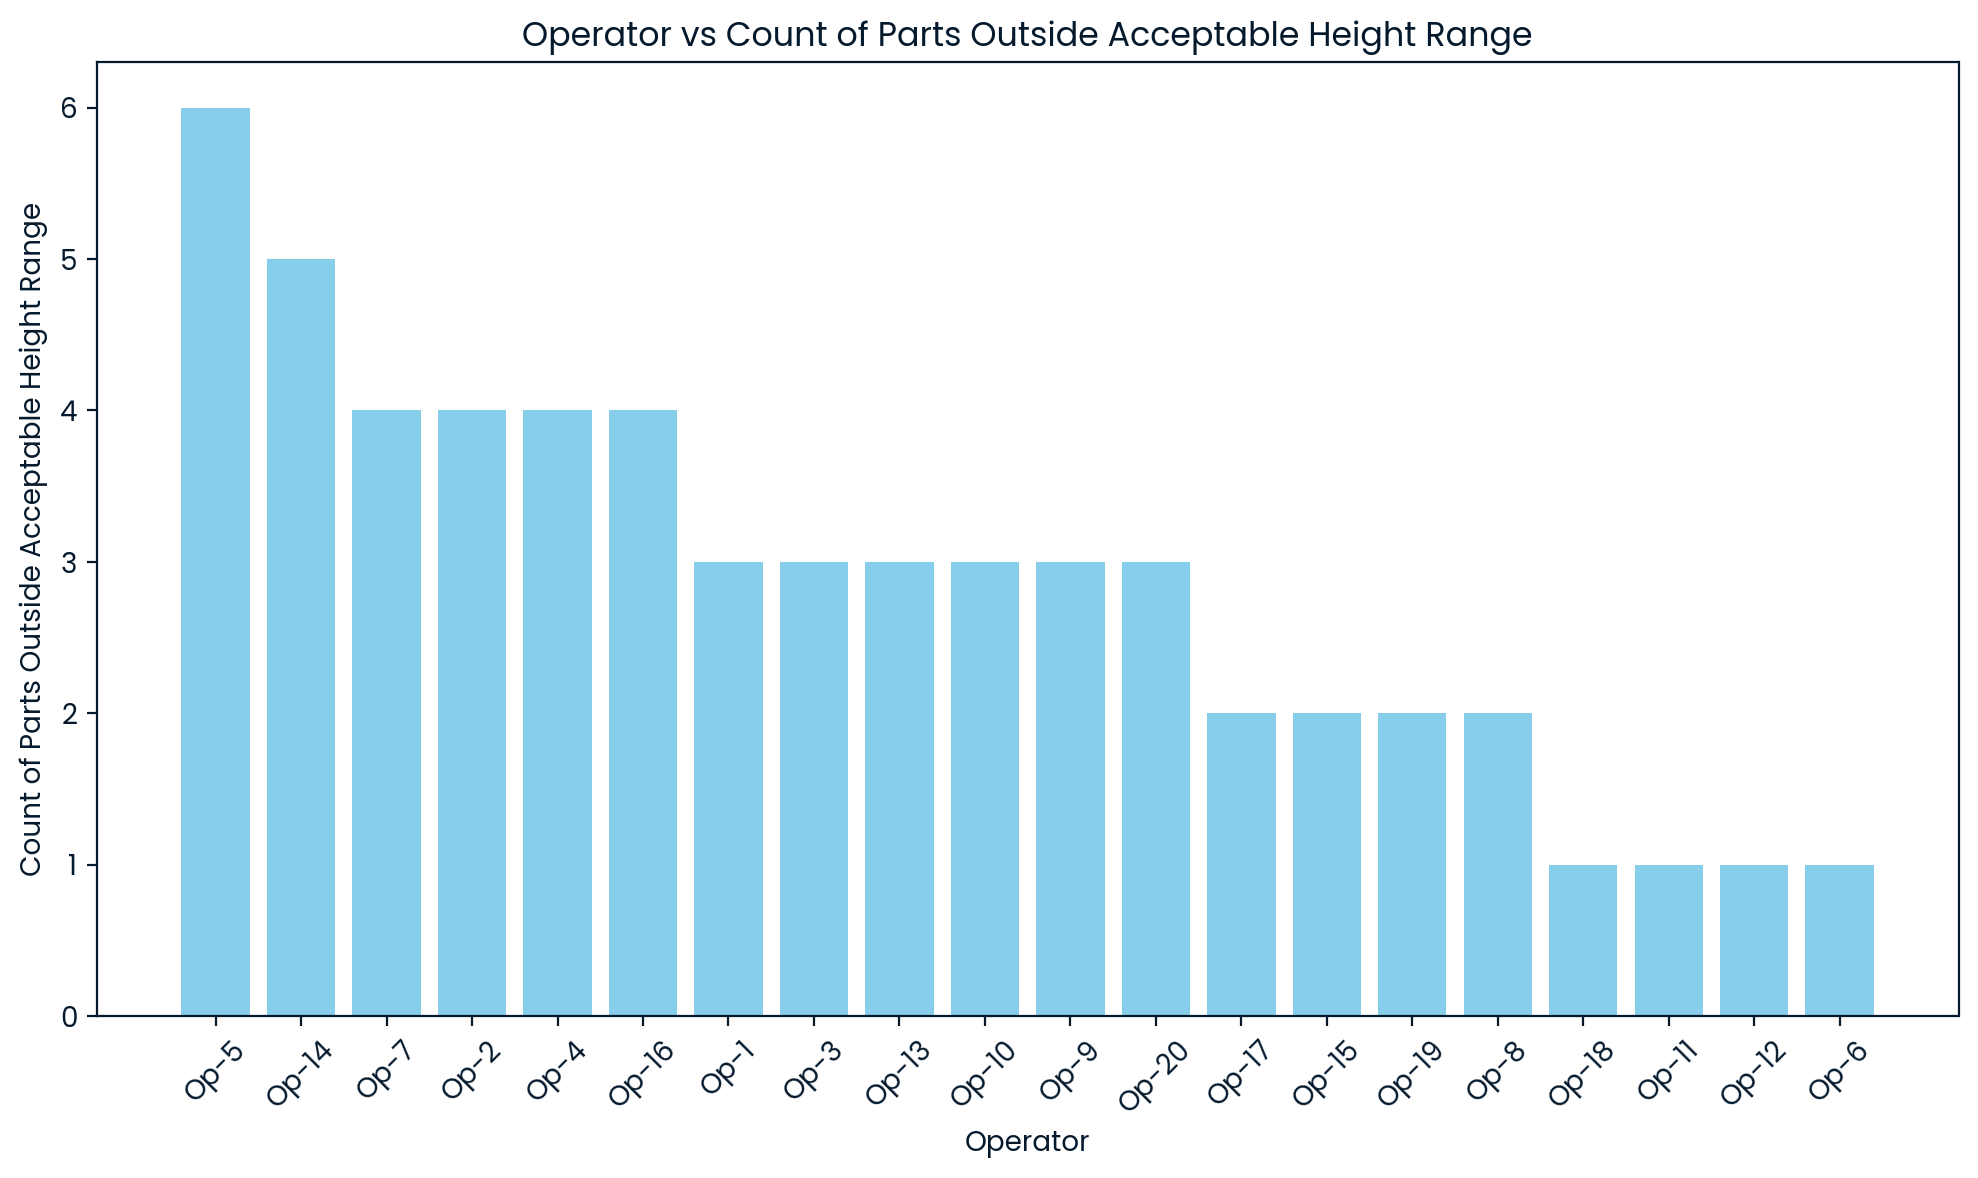

In [11]:
plt.figure(figsize=(10, 6))
plt.bar(count['operator'], count['count'], color='skyblue')
plt.xlabel('Operator')
plt.ylabel('Count of Parts Outside Acceptable Height Range')
plt.title('Operator vs Count of Parts Outside Acceptable Height Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In our analysis, we identified a total of 57 instances where the height of manufactured parts fell outside the acceptable range. This represents 11.4% of all manufactured parts, indicating a potential area for improvement in our manufacturing process. Depending on the team's quality standards, this percentage may or may not be within acceptable limits.

We found that all operators have produced at least one part outside the acceptable height range. Operator 5 had the most instances at 6 unacceptable parts, while operators 18, 1, 12, and 6 all only had 1 unacceptable part each.

On average, each operator produces approximately 2.85 parts that fall outside the acceptable height range. This average suggests that while some operators have a higher frequency of producing non-conforming parts, the issue occurs across the team.

Potential causes for parts falling outside the acceptable height range could include machine calibration issues, inconsistent material quality, or human error during the manufacturing process. Regular maintenance and calibration of machinery, stringent quality checks on raw materials, and additional training for operators could help mitigate these issues and improve overall product quality.

## Conclusion and Recommendations

In this project, we conducted an in-depth analysis of the parts produced in our manufacturing process, with a particular focus on those that fell outside the acceptable height range. Our findings revealed that a significant number of alerts were associated with specific operators, indicating potential issues in their work processes or equipment. The high frequency of these alerts suggests that there may be underlying factors such as inadequate training, equipment malfunctions, or inconsistencies in the manufacturing process that need to be addressed.

To mitigate these issues, we recommend a thorough investigation of the operators with the highest alert counts, including a review of their work methods, equipment calibration, and training records. Additionally, implementing targeted training programs, regular equipment maintenance, and process adjustments could help reduce the number of parts that do not meet the height specifications.

By taking these steps, we aim to enhance the overall quality and consistency of our manufacturing process, thereby reducing the occurrence of unacceptable parts and improving product quality.